In [199]:
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage import io
import heapq

#plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

In [200]:
class TrafficSimulation:

    def __init__(self, road_length=20, car_density=0.1, prob_slow=0.2,
                 max_speed=5):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            road_length (int) The number of cells in the road. Default: 100.

            car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.

            prob_slow (float) The probability that a car will randomly slow down
              by 1 during an update step. Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
        '''

        np.random.seed(1234)

        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow

        # Create an empty road: -1 means empty in this simulation
        self.state = np.full(self.road_length, -1, dtype=int)
        # Choose random locations to place cars
        random_indexes = np.random.choice(
            range(self.road_length),
            size=int(round(car_density * self.road_length)),
            replace=False)
        # Give each car a random initial speed from 0 to max_speed
        self.state[random_indexes] = np.random.randint(
            0, self.max_speed + 1, size=len(random_indexes))

        # Keep track of the time steps and average traffic flow at each step
        self.time_step = 0
        self.average_traffic_flow = []

        self.previous_states = []

    def update_optimized(self):
        '''
        Advance one time step in the simulation.
        '''
        # Get the location of each car
        car_indexes = np.where(self.state >= 0)[0]
        
        # If there are no cars, we have nothing to update
        if len(car_indexes) == 0:
            self.average_traffic_flow.append(0)
            self.time_step += 1
            return

        # Get the speed of each cars
        car_speeds = self.state[car_indexes]
        # Get the distance from each car to the next car
        car_distances = np.ediff1d(
            np.concatenate((car_indexes,
                            [car_indexes[0] + self.road_length])))
        # Update car speeds
        # Acceleration
        car_speeds = np.where(
            car_speeds + 1 <= self.max_speed,
            car_speeds + 1,
            self.max_speed)
        # Deceleration
        car_speeds = np.where(
            car_speeds >= car_distances,
            car_distances - 1,
            car_speeds)
        # Randomization
        moving_car_indexes = np.where(car_speeds > 0)[0]
        car_speeds[moving_car_indexes] -= (
            np.random.uniform(size=len(moving_car_indexes)) < self.prob_slow)

        # Move cars forward using their new speeds
        car_indexes += car_speeds
        car_indexes %= self.road_length
        self.state.fill(-1)
        self.state[car_indexes] = car_speeds

        # Update traffic flow history
        self.average_traffic_flow.append(sum(car_speeds) / self.road_length)
        self.time_step += 1

        self.previous_states.append(np.array(self.state))

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        prev = self.previous_states

        fig, ax  = plt.subplots(1,1, figsize= (3,3))

        for i in range(len(prev)):
            # Filter out empty cells
            y_cars = np.arange(0, len(prev[i]))[prev[i] != -1]
            
            t = [i]*len(y_cars)
            t_points = list(zip([0]*len(y_cars), y_cars))

            c = prev[i][prev[i] != -1]

            # Make colorbar a func of speed
            a = ax.scatter(y_cars, t, c = c, alpha = 0.6, marker = 'o', cmap='bone_r')

        ax.set_yticks(range(len(prev)))
        ax.set_axis_off()
        ax.set_title(f'Space-Time Diagram after {self.time_step} steps')


        #plt.colorbar(a)
        plt.gca().invert_yaxis()
        plt.show()


        return fig, ax

In [22]:
# Implementing a T-Junction 
class Road:
    def __init__(self, origin, direction, n_lanes) -> None:
        self.direction = direction
        self.origin  = origin
        self.lanes  = [-1,1]*(n_lanes//2)

class Car:
    def __init__(self) -> None:
        pass

class Lane(Road):
    def __init__(self, origin, direction, n_lanes, bearing  = 'N') -> None:
        super().__init__(origin, direction, n_lanes, env)
        self.bearing = 'N'

class Env:
    def __init__(self,n = 10) -> None:
        self.env = np.zeros((n,n))

        # Cars currently on road
        self.roads = []
        self.cars = []

    def place_road(self, origin, direction = 'NS', lanes  = 2):
        if direction == 'NS':
            # Mark Road surface
            self.env[:, origin: origin + lanes] = -1
            # Create class representation of lanes
            self.roads.append(Road(origin, direction, lanes))

        elif direction == 'EW':
            self.env[origin: origin + lanes, :] = -1
            self.roads.append(Road(origin, direction, lanes))

    def show(self):
        # TODO: something more dotty/vector fields
        plt.imshow(self.env, cmap = 'gray')

class Sim:
    def __init__(self) -> None:
        self.env = Env()
        self.v_max = 5

    def run(self, steps):
        # need a better system to ensure density
        for i in range(steps): 
            # Pick a lane and create a car
            car_road = np.random.choice(self.env.roads)
            speed = np.random.randint(1, self.v_max)
            heading = 'N'

            # place car on lane, road, env
            self.env.env[0, car_road.origin] = speed

    def step(self):
        # whole board needs to step in parallel
        print(self.env.env)
    # a function to check to turn or not?
                


In [ ]:
s = Sim()
s.env.place_road(4)
s.env.place_road(0, 'EW')

s.run(5)
s.step()

s.env.show()
# specify arrival rate for cars
# move along one



# board is just querying cars 
# env[0,0] = car.speed
# 
# car.position = (self.x, self.y)

# FOR lane in lanes:
    # For car in lane:
        # car.update()


        # update()
            # check intersection
            # check forward (lane):
            #   distance = 0 
            #   check min from me 


Separate representation of the board from the logic.
Each lane is a 1D NaSch sim

In [210]:
class Lane:
    # a 1D Nagel-Schreckenberg simulation using Cars
    def __init__(self, env, road_length = 20, car_density = 0.7, max_speed = 5, prob_slow = 0.2) -> None:
        self.road_length = road_length

        self.direction = 'EW'
        
        # TODO: arrival_rate based on empirical prior
        self.env = env
        self.time = lambda: env.curr_time

        self.representation = np.full(self.road_length, -1, dtype=int)
        self.previous_states = [self.representation]

        # Init cars or road based on Lane params // speeed limits vary by lane
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow

        self.cars = []
        car_idxs = np.random.choice(
                range(self.road_length),
                size=int(round(car_density * self.road_length)),
                replace=False)

        for i in car_idxs:
            velocity_i = np.random.randint(0 , self.max_speed + 1)
            new_car = Car(position = i,
                        velocity = velocity_i,
                        max_speed = self.max_speed, 
                        prob_slow = self.prob_slow)
            heapq.heappush(self.cars, new_car)

    def set_representation(self):
        # get positions of cars, set index
        new_representation = np.full(self.road_length, -1, dtype=int)

        for car in self.cars:
            car_idx = car.position
            car_vel = car.velocity

            new_representation[car_idx] = car_vel

        self.previous_states.append(new_representation)
        self.representation = new_representation

        return

        
    def display(self):
        #self.set_representation()
        print(''.join('.' if x == -1 else str(x) for x in self.representation))

    def update(self):
        # calculate next_pos
        cars_ = sorted(self.cars)

        for i, car in enumerate(sorted(self.cars)):
            next_car  = cars_[(i + 1) % len(self.cars)]

            dist = (next_car.position - car.position) % self.road_length
            car.calc_next_position(dist)

        # set next_pos
        for car in self.cars:
            car.update_position(self.road_length)

        self.set_representation()

    def show_lane(self):

        prev = self.previous_states

        fig, ax  = plt.subplots(1,1, figsize= (3,3))

        for i in range(len(prev)):
            # Filter out empty cells
            y_cars = np.arange(0, len(prev[i]))[prev[i] != -1]
            
            t = [i]*len(y_cars)
            t_points = list(zip([0]*len(y_cars), y_cars))

            c = prev[i][prev[i] != -1]

            # Make colorbar a func of speed
            a = ax.scatter(y_cars, t, c = c, alpha = 0.6, marker = 'o', cmap='bone_r')

        ax.set_yticks(range(len(prev)))
        ax.set_axis_off()
        ax.set_title(f'Space-Time Diagram after {ev.curr_time} Steps')


        #plt.colorbar(a)
        plt.gca().invert_yaxis()
        return fig, ax
          
class Environment:
    # Variables of sim and current time
    def __init__(self, road_length, car_density, max_speed, prob_slow) -> None:
        self.curr_time = 0
        self.lanes = [Lane(self, road_length, car_density, max_speed, prob_slow)]

    def update(self):
        for lane in self.lanes:
            # update 
            lane.update()
            # increment time
        self.curr_time += 1

class Car:
    def __init__(self, position, velocity, max_speed, prob_slow) -> None:
        self.position = position
        self.velocity = velocity

        self.next_velocity = velocity
        self.max_speed = max_speed
        self.prob_slow = prob_slow

    def __lt__(self, other):
        return self.position < other.position

    def __repr__(self) -> str:
        return f'Car at {self.position} with {self.velocity} cells/step'   

    def calc_next_position(self, dist):
        # Acceleration
        if self.velocity < self.max_speed:
            self.next_velocity = self.velocity + 1

        # Slow down
        if self.next_velocity >= dist:
            self.next_velocity = dist - 1

        # Random Transition Probability
        if self.next_velocity > 0:
            gamble = np.random.random() < self.prob_slow
            if gamble:
                self.next_velocity -= 1
    
    def update_position(self, max_length):
        self.velocity = self.next_velocity

        self.position += self.velocity
        self.position %= max_length

        

## np array vs class based comparison


<Figure size 432x288 with 0 Axes>

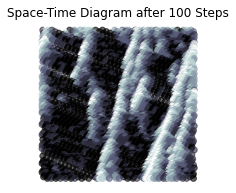

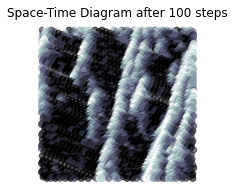

In [211]:
# Single Lane

# Set the seed so we can compare to numpy-based simulations
np.random.seed(1234)

f = plt.figure()

ev = Environment(road_length=200, car_density=0.2, max_speed=5, prob_slow=0.2)
for i in range(100):
    ev.update()

fig2, ax2 = ev.lanes[0].show_lane()

sim = TrafficSimulation(
    road_length=200, car_density=0.2, max_speed=5, prob_slow=0.2)
for i in range(100):
    sim.update_optimized()

# How well do they match?
fig, ax = sim.display()



### Plots for Pigeon Viewing Pleasure

### Life in the Fast Lane

In [205]:
# Implement lanes with directionality
# visualize lanes

# (x, loc) = state
# if NS x else 

ev.lanes
